The mouse nuclei dataset is composed of a train and test dataset. In this notebook, we 
introduce artificial spatially-correlated noise in the train data in order to showcase 
one of the limitations of Noise2Void.

In [8]:
# Imports necessary to execute the code

import matplotlib.pyplot as plt
import numpy as np
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics.config.transformations import XYFlipModel
from careamics.utils import autocorrelation
from careamics_portfolio import PortfolioManager
from PIL import Image
from scipy.ndimage import convolve

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [3]:
# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load images
train_data = np.load(files[1])["X_train"]
print(f"Train data shape: {train_data.shape}")

Train data shape: (908, 128, 128)


### Add correlated noise

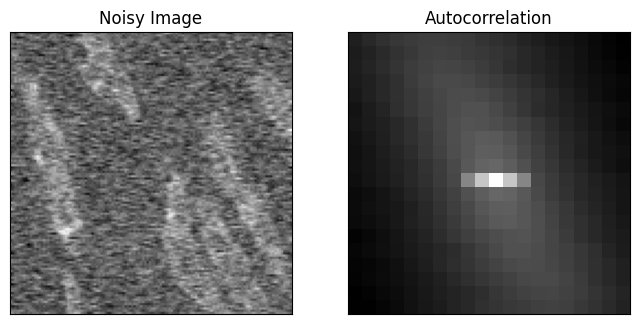

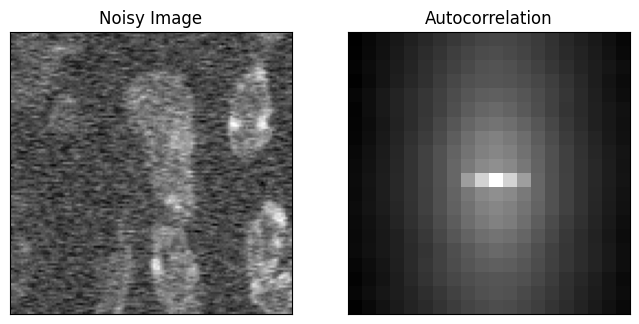

In [6]:
def get_hcorrelated_noise(noise):
    purenoise = []
    noise_kernel = np.array([[1, 1, 1]]) / 3  ## horizontal correlations

    noise = convolve(noise, noise_kernel)

    purenoise = np.array(noise)
    purenoise = purenoise - purenoise.mean()

    return purenoise


train_data_corr = np.zeros(train_data.shape)
plot_indices = [389, 621]

# add correlated noise and plot  autocorrelation for a subset of images
for i in range(train_data.shape[0]):
    # compute noise and autocorrelation
    clean_img = train_data[i]

    # create a noisy image by adding 0 mean gaussian noise
    sigma = 50
    noisy = np.random.normal(0, sigma, clean_img.shape)

    # add correlated noise
    correlated_noise = get_hcorrelated_noise(noisy)
    correlated_noisy_img = clean_img + correlated_noise

    # record the noisy image
    train_data_corr[i] = correlated_noisy_img

    # plot autocorrelation
    if i in plot_indices:
        correlated_noisy_img_autocorr = autocorrelation(correlated_noisy_img)

        # show images in one column and their correlation in the other
        # crop the correlation around (0, 0)
        midpoint = clean_img.shape[0] // 2
        crop_size = 10
        slices = (
            slice(midpoint - crop_size, midpoint + crop_size),
            slice(midpoint - crop_size, midpoint + crop_size),
        )

        fig, ax = plt.subplots(1, 2, figsize=(8, 10))
        ax[0].imshow(correlated_noisy_img, cmap="gray")
        ax[0].set_title("Noisy Image")
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(correlated_noisy_img_autocorr[slices], cmap="gray")
        ax[1].set_title("Autocorrelation")
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        plt.show()

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the 
various parameters available in CAREamics. However, a straightforward way to create a 
configuration for a particular algorithm is to use one of the convenience functions.

In [9]:
config = create_n2v_configuration(
    experiment_name="mouse_nuclei_corr_n2v",
    data_type="array",
    axes="SYX",
    patch_size=(64, 64),
    batch_size=16,
    num_epochs=30,
    use_augmentations=False,  # disable augmentations due to the correlation
)

# add X flip to the transformations
config.data_config.transforms.insert(
    0,
    XYFlipModel(
        flip_x=True,
        flip_y=False,
    ),
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'SYX',
                 'batch_size': 1,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
     

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [10]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_data_corr,
)

No working directory provided. Using current working directory: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/limitations.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/joran.deschamps/git/careamics/careamics-examples/applications/n2v/limitations/lightning_logs
Computed dataset m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 3269/3269 [02:43<00:00, 20.01it/s, train_loss_step=0.143, val_loss=0.123, train_loss_epoch=0.261]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 3269/3269 [02:43<00:00, 20.00it/s, train_loss_step=0.143, val_loss=0.123, train_loss_epoch=0.261]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is 
large we predict using tiling.

In [12]:
prediction = careamist.predict(source=train_data_corr)

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize the prediction

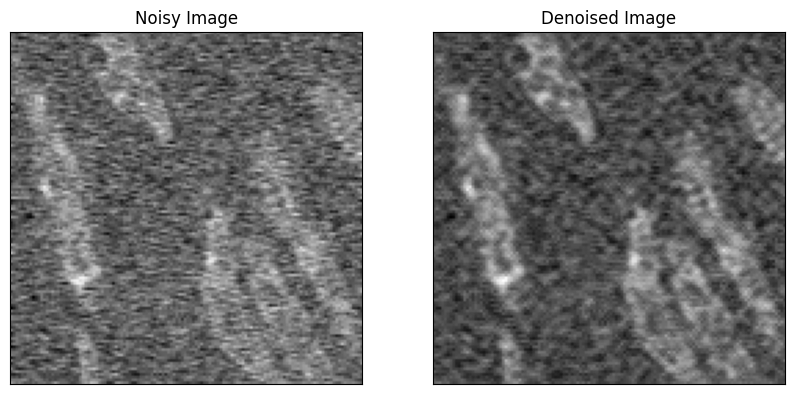

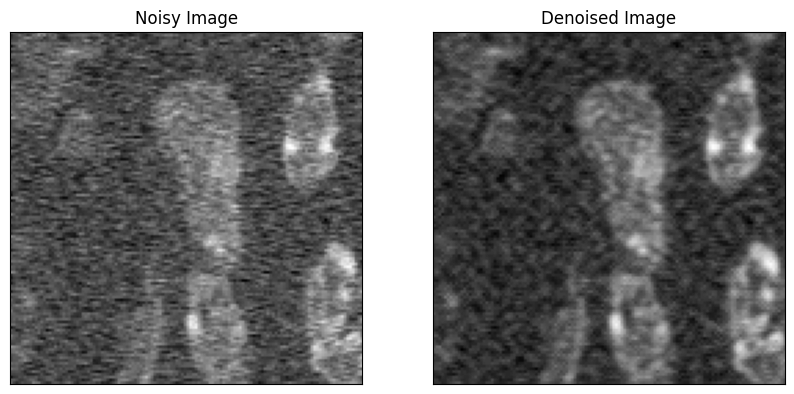

In [14]:
indices = [389, 621]

for i in indices:
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(train_data_corr[i], cmap="gray")
    ax[0].set_title("Noisy Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(prediction[i].squeeze(), cmap="gray")
    ax[1].set_title("Denoised Image")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.show()

## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the 
[BioImage Model Zoo](www.bioimage.io) format.

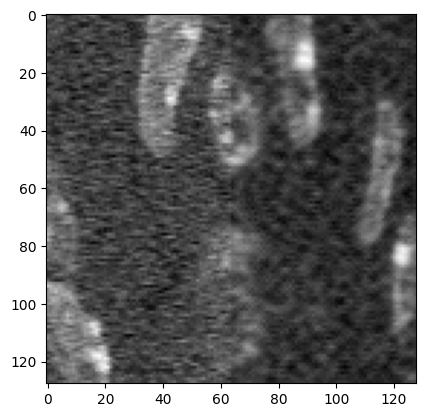

In [22]:
# create a cover image
index_cover = 5
height, width = 128, 128

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (train_data_corr[index_cover] - train_data_corr[index_cover].min()) / (
    train_data_corr[index_cover].max() - train_data_corr[index_cover].min()
)

pred = prediction[index_cover].squeeze()
norm_pred = (pred - pred.min()) / (pred.max() - pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[:height, : width // 2]
cover[:, width // 2 :] = norm_pred[:height, width // 2 :]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("SEM_Noise2Void.jpeg")